In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set up directories

In [3]:
from pathlib import Path
data_root = Path.home() / "data" / "tmp"
sample_dir = data_root / "cats_vs_dogs_sample"
model_dir = data_root / "models"

# Create test sample generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        str(sample_dir / "test"),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


# Evaluation

In [6]:
from keras.models import load_model

## Small convnet trained from scratch

In [555]:
%%time
fs_model = load_model(model_dir / "cats_and_dogs_small_from_scratch.h5")
test_loss, test_acc = fs_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

test acc : 0.73
test loss: 0.89
CPU times: user 44.9 s, sys: 4.77 s, total: 49.7 s
Wall time: 13.3 s


## Same small convnet but with data augmentation to prevent overfitting

In [556]:
%%time
fswa_model = load_model(model_dir / "cats_and_dogs_small_with_augmentation.h5")
test_loss, test_acc = fswa_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

test acc : 0.83
test loss: 0.41
CPU times: user 49 s, sys: 4.93 s, total: 53.9 s
Wall time: 14.5 s


## Use vgg16 to extract feature and then train a small dense model

In [17]:
import numpy as np

In [20]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(conv_base, directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        if ((i + 1) * batch_size) >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [21]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
test_features, test_labels = extract_features(conv_base, str(sample_dir / "test"), 1000)
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 1000 images belonging to 2 classes.


In [660]:
%%time
fe_model = load_model(model_dir / "cats_and_dogs_feature_extraction.h5")
test_loss, test_acc = fe_model.evaluate(test_features, test_labels)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

1000/1000 [==============================] - 1s 665us/step
test acc : 0.89
test loss: 0.26
CPU times: user 4.12 s, sys: 199 ms, total: 4.32 s
Wall time: 4.05 s


## Train a dense model on top of vgg16 with augmentation

In [558]:
%%time
fewa_model = load_model(model_dir / "cats_and_dogs_feature_extraction2.h5")
test_loss, test_acc = fewa_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


test acc : 0.89
test loss: 0.26
CPU times: user 13min 4s, sys: 1min 34s, total: 14min 39s
Wall time: 2min 24s


## Retrain the top layers of vgg16

In [559]:
%%time
ft_model = load_model(model_dir / "cats_and_dogs_fine_tuning.h5")
test_loss, test_acc = ft_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

test acc : 0.94
test loss: 0.32
CPU times: user 14min 54s, sys: 1min 43s, total: 16min 37s
Wall time: 2min 45s


# Show results of test images

In [600]:
import pandas as pd

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

In [601]:
models = {
    "from scratch": fs_model,
    "with augmentation": fswa_model,
    "feature extraction": fe_model,
    "fe with augmentation": fewa_model,
    "fine tuning": ft_model,
}

### Monkey patch feature extraction model to first use conv_base to extract features

In [661]:
fe_model.orig_predict = fe_model.predict

def monkey_predict(self, image_features):
    features = (conv_base.predict(image_features)
                .reshape(image_features.shape[0], 4 * 4 * 512))
    return self.orig_predict(features)

fe_model.predict = monkey_predict.__get__(fe_model, type(fe_model))

## Single test images

In [678]:
#img_name = "portokatze.jpg"
#img_name = "hund_porto.jpg"
#img_name = "hund_thailand.jpg"
img_name = "routerkatze.jpg"
img_path = str(Path(".") / ".." / ".." / "images" / img_name)

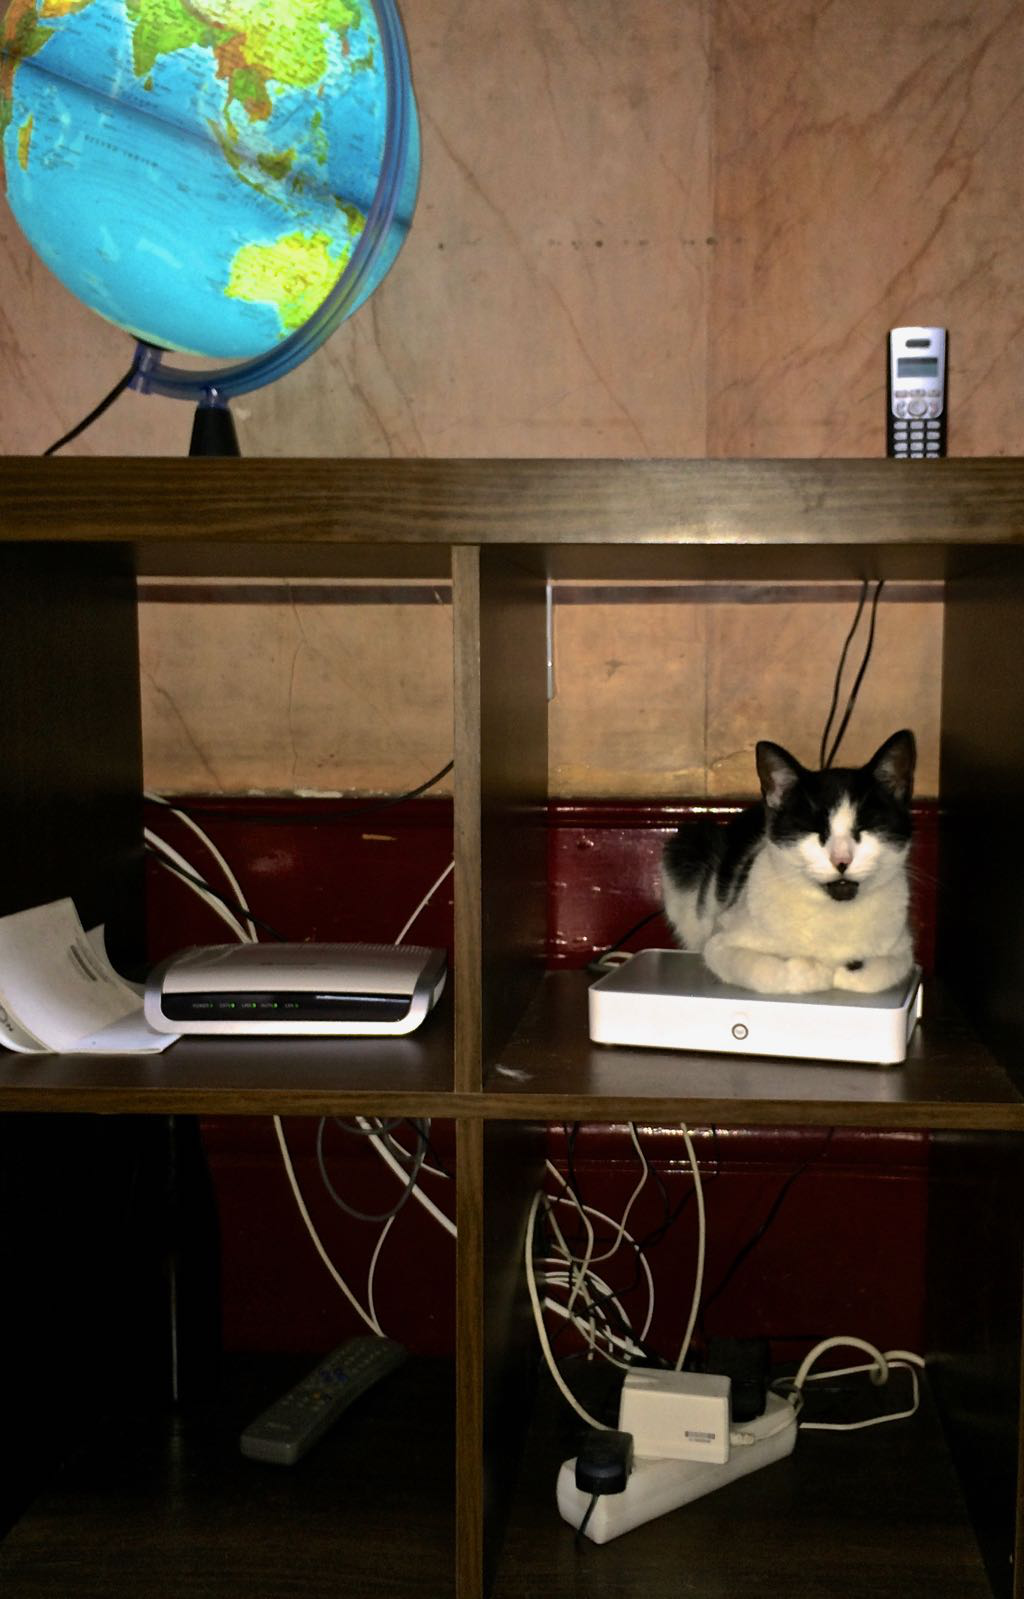

In [679]:
load_img(img_path)

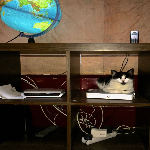

In [680]:
image = load_img(img_path, target_size=(150, 150))
image

In [681]:
image = img_to_array(image)
image_features = image.reshape((1, *image.shape)) * 1./255

In [682]:
print("Predictions:")
print("--------------------------------")
for name, model in models.items():
    proba = model.predict(image_features)[0][0]
    class_name = "dog" if proba >= 0.5 else "cat"
    print(f"{name}".ljust(21), f": {class_name} {proba:.2f}")

Predictions:
--------------------------------
from scratch          : dog 0.98
with augmentation     : cat 0.24
feature extraction    : dog 0.76
fe with augmentation  : cat 0.34
fine tuning           : cat 0.00


# Evaluate on some test images

In [683]:
num_samples = 9
base_num = 1500
cat_image_paths, dog_image_paths = [], []
for i in range(num_samples):
    img_num = base_num + i
    img_path = sample_dir / "test" / "cats" / f"cat.{img_num}.jpg"
    cat_image_paths.append(str(img_path))
    img_path = sample_dir / "test" / "dogs" / f"dog.{img_num}.jpg"
    dog_image_paths.append(str(img_path))

In [684]:
plt.figure(1, figsize=(13, 20))
for i, img_path in enumerate(cat_image_paths, 1):
    plt.subplot(3, 3, i)
    imgplot = plt.imshow(load_img(img_path))

plt.show()

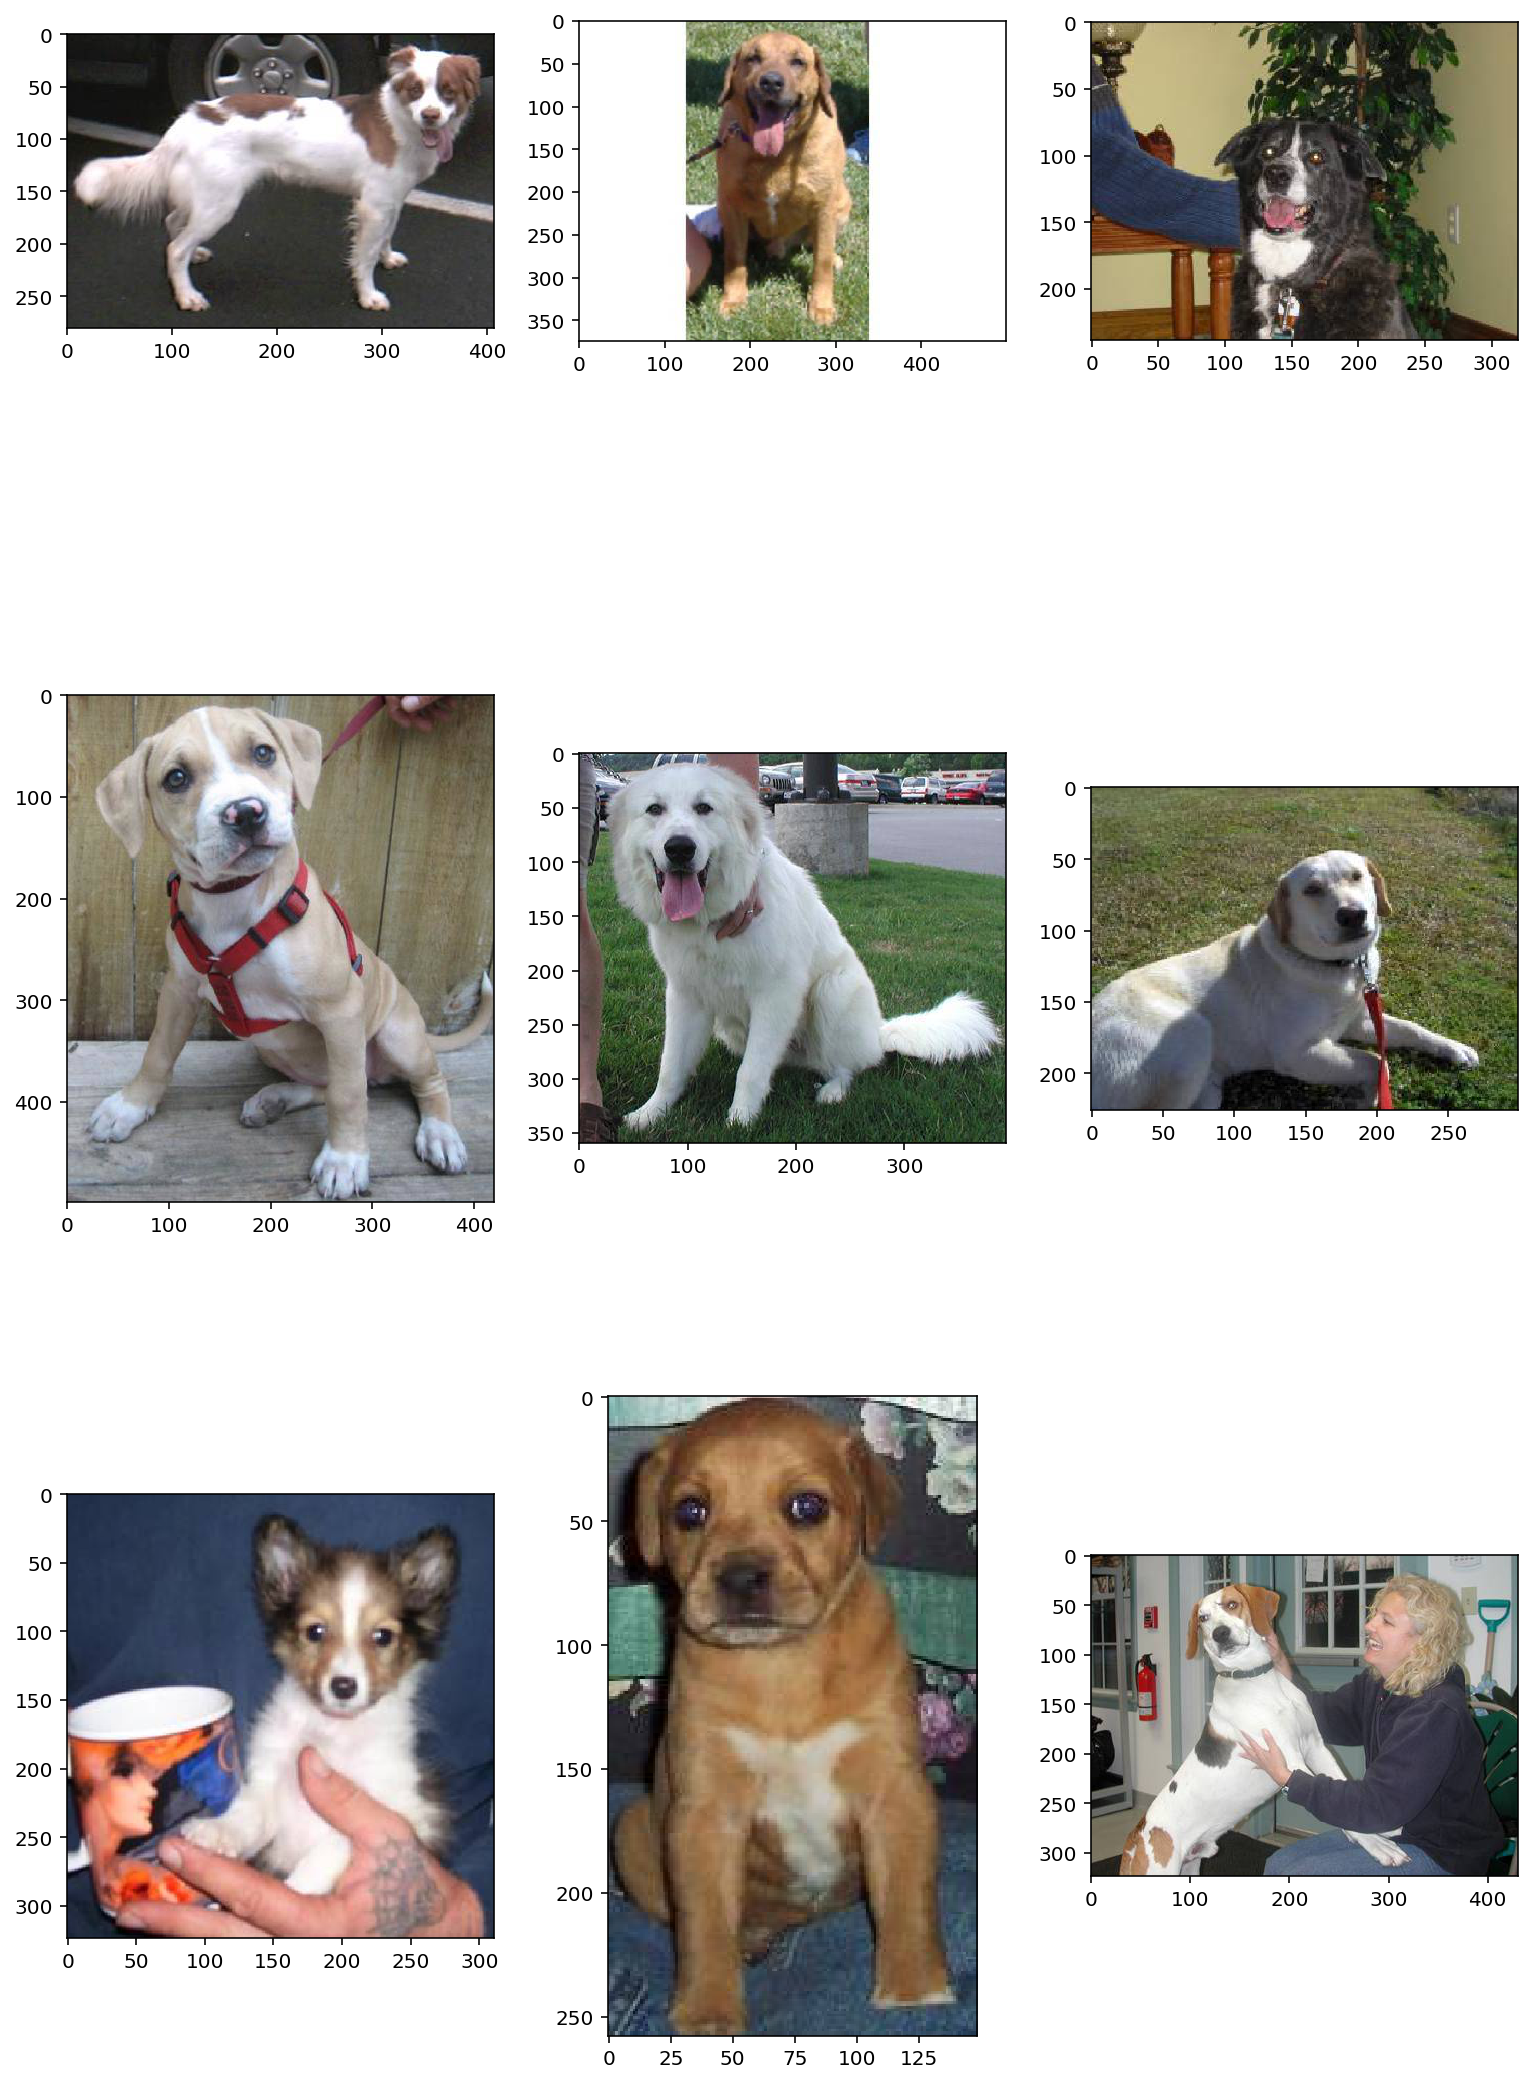

In [685]:
plt.figure(1, figsize=(13, 20))
for i, img_path in enumerate(dog_image_paths, 1):
    plt.subplot(3, 3, i)
    imgplot = plt.imshow(load_img(img_path))

plt.show()

In [686]:
images = np.array([
    img_to_array(load_img(img_path, target_size=(150, 150))) * 1./255
    for img_path in cat_image_paths + dog_image_paths
])

In [687]:
df = pd.DataFrame({
    "class": ["cat" if i < num_samples else "dog" for i in range(num_samples * 2)]
})
df["label"] = [1 if c == "dog" else 0 for c in df["class"]]

In [688]:
images = np.array([
    img_to_array(load_img(img_path, target_size=(150, 150))) * 1./255
    for img_path in cat_image_paths + dog_image_paths
])

for col, model in models.items():
    df[col] = model.predict(images)

In [689]:
df.round(2)

class  label  from scratch  with augmentation  feature extraction  \
0    cat      0          0.00               0.00                0.01   
1    cat      0          1.00               0.11                0.01   
2    cat      0          0.01               0.02                0.00   
3    cat      0          0.01               0.02                0.00   
4    cat      0          0.00               0.01                0.00   
5    cat      0          0.70               0.26                0.01   
6    cat      0          0.00               0.07                0.33   
7    cat      0          0.93               0.96                0.66   
8    cat      0          0.00               0.06                0.00   
9    dog      1          0.75               0.91                0.94   
10   dog      1          0.93               0.95                0.87   
11   dog      1          0.48               0.63                0.94   
12   dog      1          1.00               0.98                1.00   
13   dog      1          1.00               0.99                1.00   
14   dog      1          0.99               1.00                1.00   
15   dog      1          0.00               0.87                0.17   
16   dog      1          0.76               1.00                1.00   
17   dog      1          0.00               0.81                0.86   

    fe with augmentation  fine tuning  
0                   0.01          0.0  
1                   0.01          0.0  
2                   0.00          0.0  
3                   0.01          0.0  
4                   0.00          0.0  
5                   0.01          0.0  
6                   0.62          0.0  
7                   0.96          1.0  
8                   0.00          0.0  
9                   0.97          1.0  
10                  0.99          1.0  
11                  0.95          1.0  
12                  1.00          1.0  
13                  1.00          1.0  
14                  1.00          1.0  
15                  0.87          1.0  
16                  1.00          1.0  
17                  0.89          1.0

In [690]:
from sklearn.metrics import log_loss

data = {"model": [], "accuracy": [], "cross_entropy": []}
for col in ("from scratch", "with augmentation", "feature extraction", "fe with augmentation", "fine tuning"):
    data["model"].append(col)
    accuracy = (df.label == (df[col] >= 0.5)).sum() / df.shape[0]
    data["accuracy"].append(accuracy)
    cross_entropy = log_loss(df.label, df[col], eps=1e-5)
    data["cross_entropy"].append(cross_entropy)
    
dg = pd.DataFrame(data)

In [691]:
dg.round(2)

model  accuracy  cross_entropy
0          from scratch      0.67           1.47
1     with augmentation      0.94           0.27
2    feature extraction      0.89           0.21
3  fe with augmentation      0.89           0.26
4           fine tuning      0.94           0.57

# Taking a closer look at the loss function

[Sklearn User-Guide](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)

[Sklearn Apidocs](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)

[Sklearn Source](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/classification.py)

## Naive implementation

$L_{\log}(y, p) = -\log \operatorname{Pr}(y|p) = -(y \log (p) + (1 - y) \log (1 - p))$

In [875]:
%%time
losses = []
for y, p in df[["label", "from scratch"]].values:
    loss = -(y * np.log(p) + (1 - y) * np.log(1 - p))
    losses.append(loss)
log_loss = sum(losses) / len(losses)
print(log_loss)

1.4704503410329246
CPU times: user 1.53 ms, sys: 440 µs, total: 1.97 ms
Wall time: 3.77 ms


## Optimized version (like sklearn, but simplified)

In [882]:
%%time
ytrue = df.label.values.reshape(-1, 1)
ytrue = np.append(1 - ytrue, ytrue, axis=1)

ypred = df["from scratch"].values.reshape(-1, 1)
ypred = np.clip(ypred, 1e-5, 1 - 1e-5)
ypred = np.append(1 - ypred, ypred, axis=1)
ypred /= ypred.sum(axis=1)[:, np.newaxis]

log_loss = np.average(-(ytrue * np.log(ypred)).sum(axis=1))
print(log_loss)

1.4704514091345118
CPU times: user 446 µs, sys: 127 µs, total: 573 µs
Wall time: 489 µs
